# imports and installation

In [1]:
!pip install rasterio earthpy

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import basic packages
import os
import glob
import pandas as pd
import numpy as np

# deep learning related imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# visualization
import rasterio as rio
from rasterio.plot import show
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
%matplotlib inline

# Global variables

In [4]:
# Parameter
FEATURES = ['B4', 'B3', 'B2', 'B8', 'B11', 'B12', 'NDVI', "NDBI", 'MNDWI', 'NDSLI']
LABEL = ['class']
N_CLASSES = 7
CLASSES = [1, 2, 3, 4, 5, 6, 7]
PALETTE = ['#416422','#819A20', '#2389da', "#ff0000", '#ffffff', '#C2B280', '#808080']
SAMPLE_PATH = '/content/drive/MyDrive/DL/lulc_samples.csv'
IMAGE_PATH = '/content/drive/MyDrive/DL/s2_pokhara.tif'

# Preprocessing and visualization

In [5]:
df = pd.read_csv(SAMPLE_PATH)
df.head()

,B4,B3,B2,B8,B11,B12,NDVI,NDBI,MNDWI,NDSLI,class,sample
0,0.0461,0.0728,0.0901,0.2457,0.1237,0.0462,0.684030,-0.330265,-0.259033,-0.457008,1,train
1,0.0479,0.0778,0.0937,0.2903,0.1248,0.0466,0.716736,-0.398699,-0.231984,-0.445281,1,train
2,0.0491,0.0797,0.0936,0.2854,0.1290,0.0485,0.706427,-0.377413,-0.236224,-0.448624,1,train
3,0.0487,0.0789,0.0948,0.2827,0.1271,0.0474,0.706095,-0.379697,-0.233981,-0.445961,1,train
4,0.0493,0.0786,0.0944,0.2758,0.1317,0.0502,0.696709,-0.353620,-0.252496,-0.455249,1,train


In [6]:
# suffle train and test
np.random.seed(42)
df = df.sample(frac=1).reset_index(drop=True)

# # normalize df bands
# band_cols = ['B4', 'B3', 'B2', 'B8', 'B11', 'B12']
# min_val = df[band_cols].min()
# max_val = df[band_cols].max()
# mid_val = (max_val + min_val) / 2

# # normalize B* between -1 and 1
# df[band_cols] = (df[band_cols] - mid_val) / (max_val - min_val)

# df.head()

In [7]:
# train and test split
train = df[df['sample'] == 'train']
test = df[df['sample'] == 'test']

# train and test datasets
train_x = train[FEATURES].to_numpy()
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], 1)

train_y = train[LABEL].to_numpy()
train_y = to_categorical(train_y, N_CLASSES+1)

test_x = test[FEATURES].to_numpy()
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], 1)

test_y = test[LABEL].to_numpy()
test_y = to_categorical(test_y, N_CLASSES+1)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(6447, 10, 1) (6447, 8) (594, 10, 1) (594, 8)


# Deep Learning model

In [8]:
# Make model for our data
# Input shape
train_shape = train_x.shape
input_shape = (train_x.shape[1], train_x.shape[2])

print(input_shape)

# Make sequential model
model = keras.Sequential(name="model_conv1D")
model.add(keras.layers.Input(shape=input_shape))
model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_1"))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', name="Conv1D_2"))
model.add(keras.layers.Conv1D(filters=8, kernel_size=3, activation='relu', name="Conv1D_3"))
model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu', name="Dense_1"))
model.add(keras.layers.Dense(32, activation='relu', name="Dense_2"))
model.add(keras.layers.Dense(N_CLASSES+1, name="Dense_3"))
model.add(keras.layers.Activation('softmax'))
model.summary()


(10, 1)


Model: "model_conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv1D_1 (Conv1D)                    │ (None, 8, 32)               │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_2 (Conv1D)                    │ (None, 6, 16)               │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D_3 (Conv1D)                    │ (None, 4, 8)                │             392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling1D (MaxPooling1D)          │ (None, 2, 8)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_3 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 8)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,504 (21.50 KB)

 Trainable params: 5,504 (21.50 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model

# compile
model.compile(
    optimizer='Adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
earlystop = EarlyStopping(
    monitor='loss',
    patience=5
)
modelcheckpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/DL/1dcnn.h5',
    monitor='loss',
    save_best_only=True
)

# Fit the model
history = model.fit(
    x=train_x, y=train_y,
    validation_data=(test_x, test_y),
    batch_size=256,
    callbacks=[earlystop, modelcheckpoint],
    epochs=200,
)

Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.3812 - loss: 2.0532

26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - accuracy: 0.3840 - loss: 2.0518 - val_accuracy: 0.4343 - val_loss: 1.9319
Epoch 2/200
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4943 - loss: 1.7466

26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4952 - loss: 1.7275 - val_accuracy: 0.4343 - val_loss: 1.5775
Epoch 3/200
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5441 - loss: 1.2005

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5669 - loss: 1.1602 - val_accuracy: 0.5892 - val_loss: 1.1800
Epoch 4/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7394 - loss: 0.7648

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7398 - loss: 0.7629 - val_accuracy: 0.5926 - val_loss: 0.8922
Epoch 5/200
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7726 - loss: 0.5991

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7734 - loss: 0.5960 - val_accuracy: 0.6195 - val_loss: 0.6871
Epoch 6/200
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7943 - loss: 0.5387

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7945 - loss: 0.5374 - val_accuracy: 0.7997 - val_loss: 0.6273
Epoch 7/200
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8172 - loss: 0.4851

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8170 - loss: 0.4850 - val_accuracy: 0.8232 - val_loss: 0.5892
Epoch 8/200
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8178 - loss: 0.4634 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8194 - loss: 0.4602 - val_accuracy: 0.7340 - val_loss: 0.5940
Epoch 9/200
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8375 - loss: 0.4085 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8384 - loss: 0.4125 - val_accuracy: 0.7862 - val_loss: 0.5499
Epoch 10/200
20/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8442 - loss: 0.3972 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8463 - loss: 0.3939 - val_accuracy: 0.8182 - val_loss: 0.5233
Epoch 11/200
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8491 - loss: 0.3765  

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8505 - loss: 0.3759 - val_accuracy: 0.8300 - val_loss: 0.5130
Epoch 12/200
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8653 - loss: 0.3472 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8644 - loss: 0.3492 - val_accuracy: 0.8232 - val_loss: 0.4921
Epoch 13/200
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8647 - loss: 0.3369 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8647 - loss: 0.3396 - val_accuracy: 0.8367 - val_loss: 0.4826
Epoch 14/200
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8773 - loss: 0.3221 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8745 - loss: 0.3273 - val_accuracy: 0.8384 - val_loss: 0.4850
Epoch 15/200
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8625 - loss: 0.3471  

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8649 - loss: 0.3432 - val_accuracy: 0.8232 - val_loss: 0.5234
Epoch 16/200
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8708 - loss: 0.3223 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8715 - loss: 0.3230 - val_accuracy: 0.8232 - val_loss: 0.5163
Epoch 17/200
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8796 - loss: 0.3170 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8792 - loss: 0.3163 - val_accuracy: 0.8300 - val_loss: 0.4836
Epoch 18/200
16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8735 - loss: 0.3184  

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8766 - loss: 0.3143 - val_accuracy: 0.8114 - val_loss: 0.5222
Epoch 19/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8809 - loss: 0.2957 - val_accuracy: 0.8249 - val_loss: 0.4894
Epoch 20/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8707 - loss: 0.3160 - val_accuracy: 0.8232 - val_loss: 0.5047
Epoch 21/200
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8734 - loss: 0.3154  

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8744 - loss: 0.3135 - val_accuracy: 0.7963 - val_loss: 0.5297
Epoch 22/200
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8872 - loss: 0.2936  

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8857 - loss: 0.2950 - val_accuracy: 0.8300 - val_loss: 0.4585
Epoch 23/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8857 - loss: 0.2987 - val_accuracy: 0.8182 - val_loss: 0.4808
Epoch 24/200
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8828 - loss: 0.2994  

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8837 - loss: 0.2988 - val_accuracy: 0.8333 - val_loss: 0.4631
Epoch 25/200
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8875 - loss: 0.2859  

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8868 - loss: 0.2861 - val_accuracy: 0.8418 - val_loss: 0.4535
Epoch 26/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8797 - loss: 0.3104 - val_accuracy: 0.8350 - val_loss: 0.4272
Epoch 27/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8857 - loss: 0.2939 - val_accuracy: 0.8215 - val_loss: 0.4993
Epoch 28/200
16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8905 - loss: 0.2959 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8908 - loss: 0.2914 - val_accuracy: 0.8249 - val_loss: 0.5015
Epoch 29/200
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8863 - loss: 0.2934 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8883 - loss: 0.2910 - val_accuracy: 0.8215 - val_loss: 0.4747
Epoch 30/200
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8946 - loss: 0.2684 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8941 - loss: 0.2743 - val_accuracy: 0.8384 - val_loss: 0.4445
Epoch 31/200
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8967 - loss: 0.2727 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8958 - loss: 0.2753 - val_accuracy: 0.8266 - val_loss: 0.4974
Epoch 32/200
16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8958 - loss: 0.2707 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8961 - loss: 0.2743 - val_accuracy: 0.8249 - val_loss: 0.4862
Epoch 33/200
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8909 - loss: 0.2842 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8931 - loss: 0.2807 - val_accuracy: 0.8300 - val_loss: 0.4815
Epoch 34/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8952 - loss: 0.2662 - val_accuracy: 0.8249 - val_loss: 0.5071
Epoch 35/200
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9036 - loss: 0.2550  

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9017 - loss: 0.2613 - val_accuracy: 0.8350 - val_loss: 0.4588
Epoch 36/200
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8866 - loss: 0.2945 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8910 - loss: 0.2853 - val_accuracy: 0.8266 - val_loss: 0.4865
Epoch 37/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9041 - loss: 0.2579 - val_accuracy: 0.8232 - val_loss: 0.4989
Epoch 38/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9031 - loss: 0.2597 - val_accuracy: 0.8350 - val_loss: 0.4772
Epoch 39/200
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9003 - loss: 0.2692

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9006 - loss: 0.2688 - val_accuracy: 0.8350 - val_loss: 0.4491
Epoch 40/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8963 - loss: 0.2714 - val_accuracy: 0.8367 - val_loss: 0.4876
Epoch 41/200
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8996 - loss: 0.2702

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8999 - loss: 0.2698 - val_accuracy: 0.8333 - val_loss: 0.4238
Epoch 42/200
15/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9139 - loss: 0.2494 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9115 - loss: 0.2516 - val_accuracy: 0.8468 - val_loss: 0.4181
Epoch 43/200
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9089 - loss: 0.2531

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9090 - loss: 0.2530 - val_accuracy: 0.8468 - val_loss: 0.3893
Epoch 44/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9048 - loss: 0.2627 - val_accuracy: 0.8367 - val_loss: 0.4398
Epoch 45/200
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9017 - loss: 0.2585 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9027 - loss: 0.2571 - val_accuracy: 0.8384 - val_loss: 0.4225
Epoch 46/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9049 - loss: 0.2494 - val_accuracy: 0.8249 - val_loss: 0.4685
Epoch 47/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9008 - loss: 0.2588 - val_accuracy: 0.8418 - val_loss: 0.3961
Epoch 48/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8985 - loss: 0.2596 - val_accuracy: 0.8401 - val_loss: 0.4085
Epoch 49/200
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9156 - loss: 0.2362  

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9127 - loss: 0.2400 - val_accuracy: 0.8333 - val_loss: 0.4285
Epoch 50/200
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9022 - loss: 0.2535 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9042 - loss: 0.2512 - val_accuracy: 0.8266 - val_loss: 0.4657
Epoch 51/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9027 - loss: 0.2442 - val_accuracy: 0.8266 - val_loss: 0.4365
Epoch 52/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9093 - loss: 0.2489 - val_accuracy: 0.8418 - val_loss: 0.4198
Epoch 53/200
16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9169 - loss: 0.2340 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9149 - loss: 0.2377 - val_accuracy: 0.8434 - val_loss: 0.4463
Epoch 54/200
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9117 - loss: 0.2273 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9116 - loss: 0.2300 - val_accuracy: 0.8384 - val_loss: 0.4335
Epoch 55/200
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9149 - loss: 0.2404 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9147 - loss: 0.2394 - val_accuracy: 0.8535 - val_loss: 0.4045
Epoch 56/200
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9135 - loss: 0.2336 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9141 - loss: 0.2334 - val_accuracy: 0.8502 - val_loss: 0.4170
Epoch 57/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9163 - loss: 0.2392 - val_accuracy: 0.8535 - val_loss: 0.3903
Epoch 58/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9113 - loss: 0.2423 - val_accuracy: 0.8603 - val_loss: 0.4111
Epoch 59/200
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9150 - loss: 0.2226 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9150 - loss: 0.2250 - val_accuracy: 0.8586 - val_loss: 0.4158
Epoch 60/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9198 - loss: 0.2184 - val_accuracy: 0.8418 - val_loss: 0.4174
Epoch 61/200
15/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9171 - loss: 0.2205 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9172 - loss: 0.2251 - val_accuracy: 0.8434 - val_loss: 0.4140
Epoch 62/200
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9162 - loss: 0.2267 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9160 - loss: 0.2266 - val_accuracy: 0.8468 - val_loss: 0.4310
Epoch 63/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9186 - loss: 0.2243 - val_accuracy: 0.8519 - val_loss: 0.3972
Epoch 64/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9138 - loss: 0.2361 - val_accuracy: 0.8519 - val_loss: 0.3851
Epoch 65/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9160 - loss: 0.2282 - val_accuracy: 0.8552 - val_loss: 0.3879
Epoch 66/200
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9132 - loss: 0.2367  

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9150 - loss: 0.2335 - val_accuracy: 0.8636 - val_loss: 0.3889
Epoch 67/200
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9208 - loss: 0.2202 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9210 - loss: 0.2206 - val_accuracy: 0.8468 - val_loss: 0.4003
Epoch 68/200
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9158 - loss: 0.2302 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9173 - loss: 0.2266 - val_accuracy: 0.8434 - val_loss: 0.4313
Epoch 69/200
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9198 - loss: 0.2086

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9202 - loss: 0.2096 - val_accuracy: 0.8401 - val_loss: 0.4250
Epoch 70/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9262 - loss: 0.2079 - val_accuracy: 0.8535 - val_loss: 0.3954
Epoch 71/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9181 - loss: 0.2164 - val_accuracy: 0.8687 - val_loss: 0.3654
Epoch 72/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9181 - loss: 0.2226 - val_accuracy: 0.8704 - val_loss: 0.3700
Epoch 73/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9161 - loss: 0.2126 - val_accuracy: 0.8502 - val_loss: 0.4464
Epoch 74/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9149 - loss: 0.2270 - val_accuracy: 0.8468 - val_loss: 0.3903


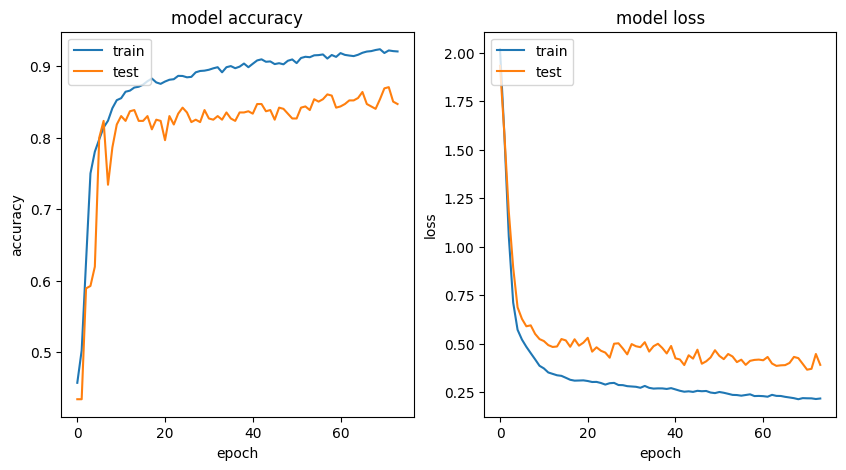

In [10]:
# plot two axis; one for accuracy and another for loss
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')

plt.show()

In [11]:
# load the best model
model = keras.models.load_model('/content/drive/MyDrive/DL/1dcnn.h5')

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
              precision    recall  f1-score   support

           1       1.00      0.99      0.99       100
           2       0.53      1.00      0.69        71
           3       0.92      0.99      0.95       169
           4       0.77      0.68      0.72        71
           6       0.98      0.73      0.84       154
           7       0.50      0.03      0.06        29

    accuracy                           0.84       594
   macro avg       0.78      0.74      0.71       594
weighted avg       0.86      0.84      0.83       594



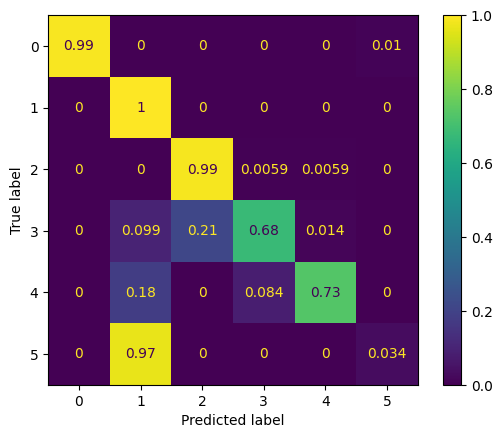

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict
prediction = np.argmax(model.predict(test_x), 1).flatten()
label = np.argmax(test_y, 1).flatten()

cm = classification_report(label, prediction)
print(cm)

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# # Classification report
# print(classification_report(label, prediction))

image_meta:  {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 3594, 'height': 2399, 'count': 10, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(8.983152841195215e-05, 0.0, 83.86446913718822,
       0.0, -8.983152841195215e-05, 28.305106118850414)}


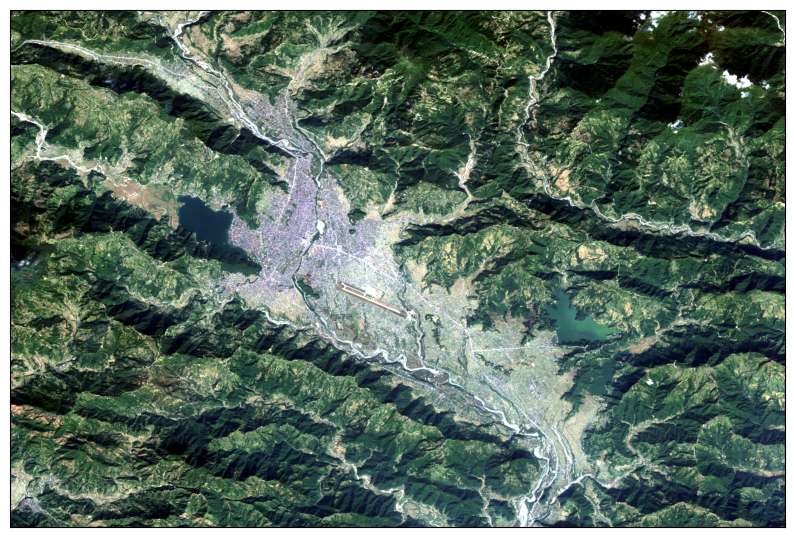

<Axes: >

In [13]:
# load image
img = rio.open(IMAGE_PATH)
print('image_meta: ', img.meta)
full_img = img.read()
rgb = full_img[0:3]

ep.plot_rgb(rgb, figsize=(10, 10), stretch=True)

In [14]:
from matplotlib.colors import from_levels_and_colors

# min_val = full_img[:6].min()
# max_val = full_img[:6].max()
# mid_val = (max_val + min_val) / 2

# full_img[:6] = (full_img[:6] - mid_val) / (max_val - min_val)

# Reshape to (height * width, bands, 1) to match the model's input shape
img_to_predict = full_img.transpose(1, 2, 0).reshape(full_img.shape[1] * full_img.shape[2], full_img.shape[0], 1)
print(img_to_predict.shape)

# Predict
prediction = model.predict(img_to_predict, batch_size=1024*1024)
prediction = np.argmax(prediction, 1)

(8622006, 10, 1)
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step


In [15]:
prediction.shape, full_img.shape

((8622006,), (10, 2399, 3594))

In [16]:
np.unique(prediction)

array([1, 2, 3, 4, 5, 6, 7])

In [17]:
prediction.dtype

dtype('int64')

<matplotlib.colors.ListedColormap object at 0x790a0f4a6210> <matplotlib.colors.BoundaryNorm object at 0x790a9e732410>


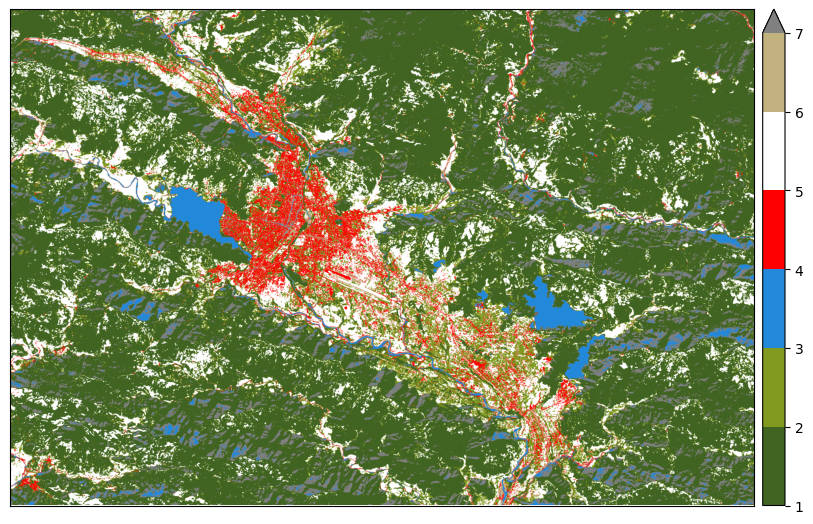

<Axes: >

In [18]:
prediction = prediction.reshape(full_img.shape[1], full_img.shape[2])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
print(cmap, norm)
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=(10, 10))

In [19]:
# Save file to drive
save_location = '/content/drive/MyDrive/DL/1dcnn_lulc_2023.tif'


new_dataset = rio.open(
      save_location,
      mode='w', driver='GTiff',
      height = prediction.shape[0], width = prediction.shape[1],
      count=1, dtype=str(prediction.dtype),
      crs=img.crs,
      transform=img.transform
)
new_dataset.write(prediction, 1);
new_dataset.close()